In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chisquare
from scipy import stats



### 1. Линейная зависимость

In [2]:

x = stats.norm().rvs(1000)
noise = np.random.uniform(-10,10)*stats.norm().rvs(x.size)
y_clear = x 
y = y_clear + noise

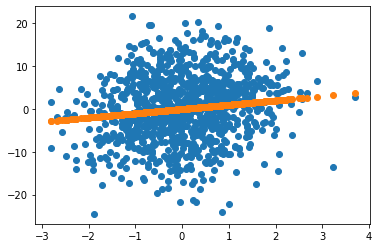

In [3]:
plt.scatter(x, y);
plt.scatter(x, y_clear);

In [4]:
def is_negative_corr_pearson(x, y, l, r):
    n = len(x)
    r_coeff = np.corrcoef(x, y)
    T = r_coeff[0, 1]*np.sqrt(n - 2)/np.sqrt(1 - r_coeff[0, 1]**2)
    if (T > l) and (T < r):
        return 1
    else:
        return 0

In [5]:
def is_negative_spearman(x, y, alpha=0.05):
    _, pvalue = stats.spearmanr(x, y)
    if pvalue <= alpha:
        return 0
    else:
        return 1

In [6]:
def get_contingency_table(x, y, isdraw = False):
    def mapX(x_var, x_025, x_075):
        if x_var < x_025:
            return '1) less x_025'
        if x_var > x_075:
            return '3) more x_075'
        if (x_var >= x_025) and (x_var <= x_075):
            return '2) between x_025 and x_075'

    def mapY(y_var, y_025, y_075):
        if y_var < y_025:
            return '1) less y_025'
        if y_var > y_075:
            return '3) more y_075'
        if (y_var >= y_025) and (y_var <= y_075):
            return '2) between y_025 and y_075'


    df = pd.DataFrame({'X':x, 'Y':y})
    x_quant = df.X.quantile([0.25, 0.75])
    y_quant = df.Y.quantile([0.25, 0.75])
    df['Interval_X'] = df.X.apply(lambda x: mapX(x, x_quant.tolist()[0], x_quant.tolist()[1]))
    df['Interval_Y'] = df.Y.apply(lambda y: mapY(y, y_quant.tolist()[0], y_quant.tolist()[1]))
    df['Ones'] = 1

    if isdraw:
        fig, ax = plt.subplots(figsize = (7, 7))
        df[['X', 'Y']].plot.scatter(x = 'X', y = 'Y', ax = ax, label = 'Points ')
        ax.vlines(x_quant, ymin = df.Y.min(), ymax = df.Y.max(), color = 'red', label = 'X interval')
        ax.hlines(y_quant, xmin = df.X.min(), xmax = df.X.max(), color = 'blue', label = 'Y interval')
        ax.legend()
        plt.show()

    return df[['Interval_X',	'Interval_Y', 'Ones']].pivot_table(index='Interval_X', columns='Interval_Y', aggfunc='count').values

In [7]:
def is_negative_chi_square(x, y, alpha=0.05):
    contingency_table = get_contingency_table(x, y)
    pvalue = stats.chi2_contingency(contingency_table)[1]
    if pvalue <= alpha:
        return 0
    else:
        return 1

In [8]:
np.random.seed(42)
negatives_corr_pearson = 0
negatives_spearman = 0
negatives_chi_square = 0
alpha = 0.05

n = 1000 # размер выборки
n_tests = 1000 # количество повторений теста

left_border, right_border = stats.t.ppf(alpha/2, df=n-2), stats.t.ppf(1-alpha/2, df=n-2)

for i in range(n_tests):  
    # генерация выборок
    x = stats.norm().rvs(n)
    noise = stats.norm(0, 10).rvs(n)
    y = x + noise

    negatives_corr_pearson += is_negative_corr_pearson(x, y, l=left_border, r=right_border)
    negatives_spearman += is_negative_spearman(x, y, alpha=alpha)
    negatives_chi_square += is_negative_chi_square(x, y, alpha=alpha)
print(f'Ошибка второго рода: корреляция Пирсона: {negatives_corr_pearson/n_tests:.3f}')
print(f'Ошибка второго рода: корреляция Спирмена: {negatives_spearman/n_tests:.3f}.')
print(f'Ошибка второго рода: X2: {negatives_chi_square/n_tests:.3f}.')

Ошибка второго рода: корреляция Пирсона: 0.107
Ошибка второго рода: корреляция Спирмена: 0.123.
Ошибка второго рода: X2: 0.483.


### 2. Монотонная нелинейная зависимость

In [9]:
rng = np.random.default_rng()
x = stats.uniform(-5, 10).rvs(1000)
noise  = stats.norm(0,1).rvs(x.size)
y_clear = 1 / (1 + np.exp(1-x))
y = y_clear + noise




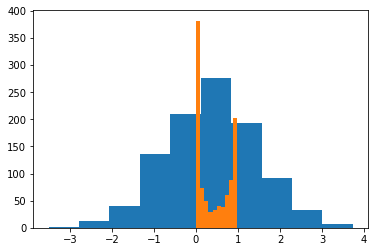

In [10]:
plt.figure()
plt.hist(y);
plt.hist(y_clear);

(-1.9975147302149998, 2.9820132543115534)

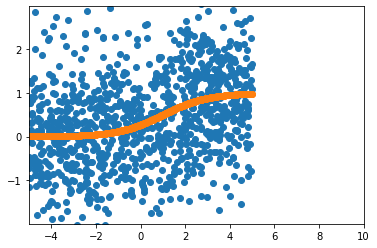

In [11]:
plt.scatter(x, y, label = 'Noised');
plt.scatter(x, y_clear, label = 'Based');
plt.xlim(-5, 10)
plt.ylim(np.min(y_clear)-2, np.max(y_clear)+2 )

In [12]:
np.random.seed(42)
negatives_corr_pearson = 0
negatives_spearman = 0
negatives_chi_square = 0
alpha = 0.05

n = 1000 # размер выборки
n_tests = 1000 # количество повторений теста

left_border, right_border = stats.t.ppf(alpha/2, df=n-2), stats.t.ppf(1-alpha/2, df=n-2)

for i in range(n_tests):  
    # генерация выборок
    x = stats.uniform(-5, 10).rvs(n)
    noise  = stats.norm(0,5).rvs(x.size)
    y_clear = 1 / (1 + np.exp(1-x))
    y = y_clear + noise

    negatives_corr_pearson += is_negative_corr_pearson(x, y, l=left_border, r=right_border)
    negatives_spearman += is_negative_spearman(x, y, alpha=alpha)
    negatives_chi_square += is_negative_chi_square(x, y, alpha=alpha)
print(f'Ошибка второго рода: корреляция Пирсона: {negatives_corr_pearson/n_tests:.3f}')
print(f'Ошибка второго рода: корреляция Спирмена: {negatives_spearman/n_tests:.3f}.')
print(f'Ошибка второго рода: X2: {negatives_chi_square/n_tests:.3f}.')

Ошибка второго рода: корреляция Пирсона: 0.400
Ошибка второго рода: корреляция Спирмена: 0.416.
Ошибка второго рода: X2: 0.749.


### 3. Немонотонная зависимость

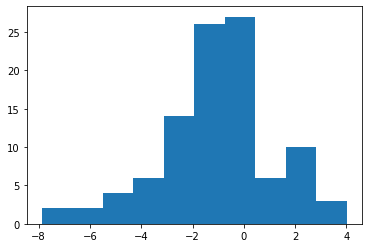

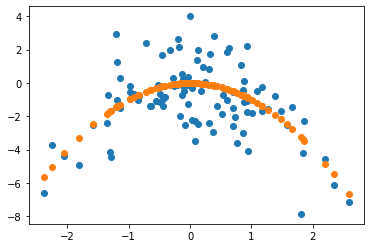

In [13]:
rng = np.random.default_rng()
x = stats.norm().rvs(100)
noise  = stats.norm(0, 1.5).rvs(x.size)
y_clear = -x**2
y = y_clear + noise

plt.figure()
plt.hist(y);
plt.figure()
plt.scatter(x, y);
plt.scatter(x, y_clear);

In [14]:
np.random.seed(42)
negatives_corr_pearson = 0
negatives_spearman = 0
negatives_chi_square = 0
alpha = 0.05

n = 1000 # размер выборки
n_tests = 1000 # количество повторений теста

left_border, right_border = stats.t.ppf(alpha/2, df=n-2), stats.t.ppf(1-alpha/2, df=n-2)

for i in range(n_tests):  
    # генерация выборок
    x = stats.norm().rvs(n)
    noise = stats.norm(0, 5).rvs(n)
    y = -x**2 + noise

    negatives_corr_pearson += is_negative_corr_pearson(x, y, l=left_border, r=right_border)
    negatives_spearman += is_negative_spearman(x, y, alpha=alpha)
    negatives_chi_square += is_negative_chi_square(x, y, alpha=alpha)
print(f'Ошибка второго рода: корреляция Пирсона: {negatives_corr_pearson/n_tests:.3f}')
print(f'Ошибка второго рода: корреляция Спирмена: {negatives_spearman/n_tests:.3f}.')
print(f'Ошибка второго рода: X2: {negatives_chi_square/n_tests:.3f}.')

Ошибка второго рода: корреляция Пирсона: 0.914
Ошибка второго рода: корреляция Спирмена: 0.941.
Ошибка второго рода: X2: 0.018.
